# Tutorial Week 6: Web Scraping Data

## Introduction
In this tutorial, you will get practical exposure to web scraping techniques.

# EXERCISE 1 - Scraping Data from a Website

In the lecture, we demonstrated how to extract data from a given website using Unix command line tools. In this tutorial, we will learn how to do so with Python.

We will use the following Python libraries:
- **Request**         for interacting with websites and web services
- **Beautiful Soup**  for webpage parsing



Our goal is to load data from the following website that makes available historic data about the convict transportations to Australia in the late 18th and 19th century from the British Convict Transportation Register: https://convictrecords.com.au

Let's start by having a look at the actual webpage.
The following code requests the webpage for **the ship 'Batavia'** from this ConvictRecords website (the given URL scheme is specific for this website):

In [ ]:
import requests
webpage_source = requests.get("https://convictrecords.com.au/ships/batavia/").text
print(webpage_source)

What you see above as the output of this request is the raw webpage source code.
This is normally parsed and rendered by a web browser as a nice visual webpage.

The language in which this webpage is written, is called **HTML** (the *Hypertext Markup Language*).
In order to extract data from a webpage, we need at least some understanding of HTML, and in particularm that it is describing a tree-like structure of content elements which are rendered by a web browser.

We can interpret the content of this webpage also inside a program by using a so-called **HTML parser**.
For Python, there are several different options. In this tutorial, we are using a parser called *Beautiful Soup*. This parser allows a Python program to extract content of a webpage or a web service by finding specific HTML tags and giving access to the content inside.

A webpage in HTML generally has a lot of tags that allow the seperation of content within the page. However, we need some way to model or organise this content and address. For this purpose we use two primary methods (covered in the week 06 lecture notes), the Document Object Model (or DOM) and css selectors.

## Document Object Model

The Document Object Model basically converts a website into a tree-like structure for easy traversal. We can look at slide no. 29 in the lecture notes to see an example of this representation:
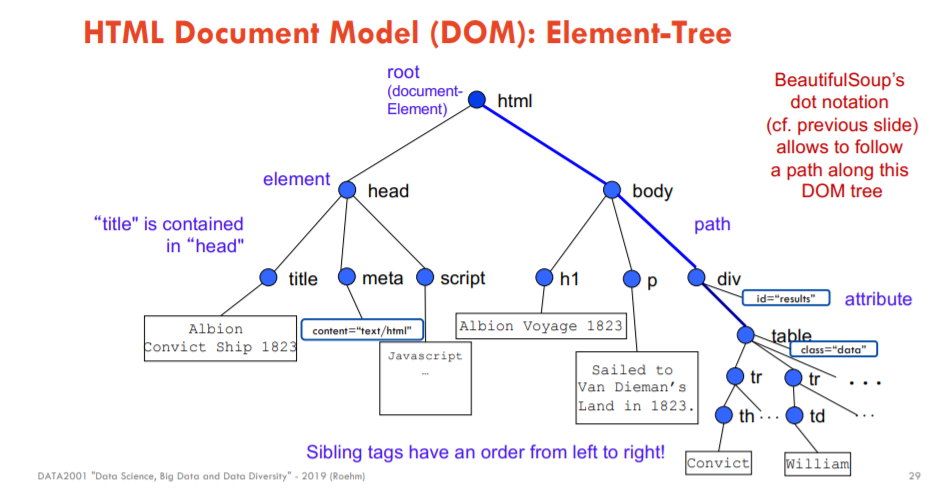

## CSS Selectors

Another way to navigate the HTML document is by using 'shortcuts' that rely on addresses that are used in Cascading Style Sheets (CSS). A CSS file is like a theme files that can change how a page is displayed. The do this by navigating to a particular portion of the HTML document that is identified by a selector and then applying the modifications in the CSS file.

However, for our purposes, we only need to worry about how that navigation system works. Slide 30 of the lecture material is helpful here:
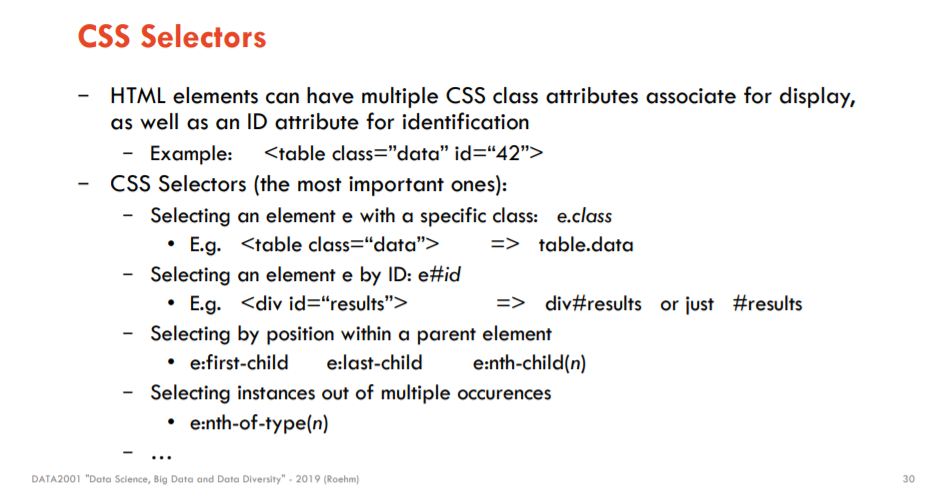

Have a look at the following Python code. It shows how the BeautifulSoup library is used to parse the webpage source code and then demonstrates different navigational commands of that library to identify specific tags within a (complex) page:

In [ ]:
from bs4 import BeautifulSoup
page_content = BeautifulSoup(webpage_source, 'html5lib')

# Example 1: print the title element of the page content
print("Example 1: get a specific HTML element - such as the page title")
print(page_content.title)

# Example 2: print just the text of the title element using the 'text' operator
print("\nExample 2: get HTML element's text content")
print(page_content.title.string)

# Example 3: navigate along a tag sequence path and print content
print("\nExample 3: navigate along an element path to some content inside the page")
print(page_content.body.div['id'])

# Example 4: find ALL hyperlinks on the page (anywhere on the page, just print URL)
print("\nExample 4: find_all() URLs of hyperlinks on this webpage")
for link in page_content.find_all("a"):
    if (link.has_attr('href')):  
        print(link.get('href'));

## Exercise 1a:

Ok, now that we have learned a bit about how to navigate in a webpage, let's get to work:

What we would like to do in this exercise is to extract the ship voyage information from this page.

When you scroll around the HTML code, you will see a around the last third of the source code an element
> &lt;div id="ship"&gt; 

>    &lt;h1&gt;Batavia Voyages to Australia&lt;/h1&gt;
 
which describes the ship Batavia and its voyage to Australia in 1817 in a few more details.

Lets use Python to extract just this part.
To do so, we use the Beautiful Soup library to search for an HTML tag with id="ship", extract it from the page into a variable *shipdetails*, and print it out:

In [ ]:
from bs4 import BeautifulSoup

page_content = BeautifulSoup(webpage_source, 'html5lib')
shipdetails  = page_content.find(id="ship")
print(shipdetails)

This looks already like some useful information, but there is still a lot of HTML formatting code included here.
The **text** function allows us to just print all the printable text inside an HTML code fragment:

In [ ]:
print(shipdetails.text)

Ok, we are close. Now lets extract indiviudal parts of this text into some variables. To do so, we need to analyse and parse the actual HTML structure in which this text is contained.

Checking back with the HTML fragment, we note that the ship name is used as alternative text for the image of the ship. We can extract this with an **path expression** that looks for the first **img** tag in the ship details, and then extracts the value of its **alt** attribute.

In [ ]:
shipname = shipdetails.img['alt']
print(shipname)

There is a subheading (**h3**) in the text that tells us the sailing date.
This time, the text we are interested in is not an attribute of the element, but rather the text **string** inside the element. 
We do this as follows:

In [ ]:
voyage = shipdetails.h3.string
print(voyage)

We also can get the URL for the subpage with the details of that voyage from this h3 element:

In [ ]:
voyagedetails = shipdetails.h3.a["href"]
print(voyagedetails)

Finally, let's get the information about when the ship arrived somewhere. This is a bit tricky because this part of the webpage has mixed content of a **h3** heading followed just by text without an enclosing HTML tag. If you draw the structure of our content fragment as a tree, you see that this text sits on the same level under the enclosing **div** element than the **h3** title in front of it. In the terminology of a tree, this is a **sibling** (the next sibling) to the h3-heading. 

So we need to tell the BeautifulSoup library to navigate along the HTML content exactly this way:
From the **div** element (pointed to by the *shipdetails* variable) on to the **h3** heading element, then to its next  sibling content element which is the text about the arrival date:

In [ ]:
arrivaldate = shipdetails.h3.next_sibling.string
print(arrivaldate)

The above code is actually a shortcut. The h3-heading and the text are actually contained in a list further inside the HTML tree. The complete correct path to this element is shown below - but luckily BeautifulSoup allows us to use a shortcut, interpreting each dot-stop (.) as a 'next level or any level below' direction:

In [ ]:
print("Arrival date found along the complete HTML path:")
arrivaldate = shipdetails.div.ul.li.h3.next_sibling.string
print(arrivaldate)

There seems to be some extra whitespace arount this arrival text; this can be removed using the **strip()** function on text.

Ok, putting this all together as just one code, we get the following web scraping program for Ship details.


In [ ]:
import requests
from bs4 import BeautifulSoup

# retrieve the source code of the webpage
page_html = requests.get("https://convictrecords.com.au/ships/batavia/").text

# parse the HTML content of the webpage and extract the ship's details part
page_content = BeautifulSoup(page_html, 'html5lib')
shipdetails = page_content.find(id="ship")

# extract selected information from the shipdetails, based on page structure
shipname = shipdetails.img['alt']
voyage = shipdetails.h3.text
voyagedetails = shipdetails.h3.a["href"]
arrivaldate = shipdetails.h3.next_sibling.string

# print out retrieved values
print("Ship Name:  " + shipname)
print("Voyage:     " + voyage)
print("Voyage URL: " + voyagedetails)
print(arrivaldate.strip()) #remove extra whitespace from text

For more documentation about functions available in BautifulSoup, see here:
https://www.crummy.com/software/BeautifulSoup/bs4/doc/

## Exercise 1b:

What happens if a ship did more than just a single voyage?

In this case, its webpage would show a list of voyages - and our processing would need to be adjusted to be able to work with those lists.

Let's see on how this work on the example of the ship 'Adelaide' which did 3 voayges to Australia between 1849 and 1863:

In [ ]:
import requests
from bs4 import BeautifulSoup

# retrieve the source code of the webpage
page_html = requests.get("https://convictrecords.com.au/ships/adelaide/").text

# parse the HTML content of the webpage and extract the ship's details part
page_content = BeautifulSoup(page_html, 'html5lib')
shipdetails = page_content.find(id="ship")
print(shipdetails)

It seems that the format of the ConvictRecords web page is such that different voyages for the same ship are listed each with its own **h3** element followed by some text and links.
Our code above would so far only retrieve the first voyage though.
We need to adjust it such that it also works with multiple **h3** elements:

In [ ]:
# extract selected information from the shipdetails, based on page structure
shipname = shipdetails.img['alt']
voyages = shipdetails.find_all("h3") # this finds ALL h3 elements describing voyages
voyage = []
voyurl = []
voyarrival = []
for v in voyages:
    voyage.append(v.text)
    voyurl.append(v.a["href"])
    voyarrival.append(v.next_sibling.string.strip())

# print out retrieved values
print("Ship Name: " + shipname)
print("The " + shipname + " made " + str(len(voyage)) + " voyages to Australia.")
#print(voyage)
for i in range(len(voyages)):
    print("Voyage "+str(i+1)+": " + voyage[i])
    print("     URL: " + voyurl[i])
    print("     "+voyarrival[i])

## YOUR TASK: Extract the passenger list from the voyage of the Glory

In the lecture, we did briefly demonstrate how to extract a passenger list from a HTML table on a webpage on the ConvictRecords site. We used Unix tools there - your task here in this tutorial is to do the same with Python.

The **table** tag in HTML has the following general structure:

   tag names           | description
   :------------------:|:------------------------------------------------------
   **table**           | start tag of a HTML table
   **tr** ... **/tr**  | start and end tags of a table *row*
   **th** ... **/th**  | optional: start and end of a *header* field
   **td** ... **/td**  | td tags encapsulate a *single data field* within a table
   **/table**          | end tag of a table
   

Extract the *passenger list* from the **1818 journey** of the **ship Glory**, with the following constraints:
 - Extract the data into a Python **list** variable called **passengers** which is either a **list of strings** or better, a  **list of dictionary** data structure
 - As we already found out above, the url to this voyage is:<br>
   https://convictrecords.com.au/ships/glory/1818

In [ ]:
# TODO: replace the content of this cell with your Python web scraping solution
raise NotImplementedError

## Web Scraping with Google Spreadsheets

As a side note: If the data is given as a table or an item list, you can retrieve the structured data also in Google Spreadsheets using its **ImportHTML()** function:

In [ ]:
# login to Google Spreadsheet
# Type into the first cell:
# =ImportHTML("https://convictrecords.com.au/ships/glory/1818", "table", 1)

Note however that this **only works for table or list data** (so not for our initial example with the structured ship details), and that you would need to do so manually for each individual webpage. With a dataset of about 1200 different ship voyages, this is not really an option...

# EXERCISE 2: Data Cleansing

Once we retrieved data, we typically need to do some cleansing steps. This is especially important for data scraped from webpages because many websites are not written with providing consistent data for a data analysis task in mind.

## Special Characters in Scraped Data

The first issue we have to be aware of is that the scraped data can include all kinds of special characters, some of which have special meaning in our target data models. 

For example, CSV files use commas (",") or tabs as a delimiter character between fields. If the text within one of such fields contains a comma (or tab) itself, the CSV file cannot be parsed correctly anymore. To avouid this, we need to **quote** all texts that potentially contain those special characters in CSV. Luckily, the csv write function in python allows us to do so as we will see later.

Another special character is the single quote ("'"). This one is used in SQL to encapsulate strings. But what if a string itself includes a single quote? we have then to *escape* it first.

Let's have a look on whether we find any single quote in our current passenger list from the ship **"Glory"**:

In [ ]:
for p in passengers:
    if (p['Convict'].find("'") > 0): 
        print (p['Convict'])
    if (p['Description'].find("'") > 0): 
        print (p['Description'])
    if (p['Convicted_At'].find("'") > 0): 
        print (p['Convicted_At'])

And indeed we seem to have one entry in this passenger list where a name with a aphostrophe is used. This is however the same character then the SQL single quote.

Now luckily, the python libraries for working with CSV files and with PostgreSQL are robust enough and will handle these special characters gracefully (at least with the utility functions which we provide below, and if you use dictionaries as data structures). **In our case, we do not need to do anything at this stage.**

In other cases however this might now require some pre-processing on your side such as escaping any single quotes or replacing them. It is also a good practice to use dictionary data structures rather than lists because they use attribute key names rather than relaying on positions.

## General Data Cleansing

For the next exercise, look at the 'Crimes' page on the ConvictRecords website:<br>
 https://convictrecords.com.au/crimes

This page is a good example for potential inconsistencies on a webpage, which we would like to avoid.

## YOUR TASK: Check and Discuss Data Inconsistencies in 'Crimes' list

- Write Python code to read the 'Crimes' page from the ConvictRecords website, and extract the crimes list (just textual would be fine):  https://convictrecords.com.au/crimes
- Check the content of this webpage and checkfor any data inconsistencies.
- Discuss with your class mates and tutor your findings - and how you would handle each case.

In [ ]:
# TODO: replace the content of this cell with your solution and discussion points
raise NotImplementedError

### Discussion Area
use this markdown cell to discuss the records from above

# EXERCISE 3: Data Storage
Lets finally look at how we can store the extracted data in either a CSV file or a database for further processing. 

For the **CSV output** use the **csv** library of Python.<br>
It is documented here: https://docs.python.org/2/library/csv.html

For the **PostgreSQL** database output, use the **sqlalchemy** and **psycopg2** libraries as we used already in Week 4.

## Exercise 3a: Writing Scraped Data to a CSV File

The first obvious export format for structured data, which we retrieved from a webpage, is a CSV file. 

Ideally, you chose to use Pandas to push the data into a dataframe, since it was the easiest. We can just use the to_csv method() to solve this task. Check out https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html for some help with particular parameters

## YOUR TASK: Write Passenger List as a CSV File

Output your passenger list from the **passengers** variable as CSV file.
**Hint:** You may wish to check the state of your DataFrame to see what columns are being written and which columns you might wish to write to CSV (like the index column for example)

In [ ]:
# TODO: replace the content of this cell with your Python solution
raise NotImplementedError

## Exercise 3b: Writing Scraped Data to a Database

In the next step, we are looking into how to store the scraped data directly into a PostgreSQL database. To do so, we copy the following two utility functions from Week 4 to connect to PostgreSQL and to execute an SQL command there from Python.

Please edit in the following cell the variables **YOUR_UNIKEY** and **YOUR_PW** to match your own PostgreSQL login.

In [ ]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

def pgconnect():
    # please replace <your_unikey> and <your_SID> with your own details
    YOUR_UNIKEY = '<your_unikey>'
    YOUR_PW     = '<your_SID>'
    DB_LOGIN    = 'y20s1d2x01_'+YOUR_UNIKEY
    HOSTNAME    = 'soitpw11d59.shared.sydney.edu.au'

    try:
        db = create_engine('postgres+psycopg2://'+DB_LOGIN+':'+YOUR_PW+'@'+HOSTNAME+'/'+DB_LOGIN, echo=False)
        conn = db.connect()
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return db,conn

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

## YOUR TASK: Store Passenger List in Database
Your task is as follows:
* Create a table in your PostgreSQL database that is suitable for the passenger data retrieved from above's webpage.
* Insert the extracted information of the passengers of the 1818 voyage of the Glory in that table
* Query your database for how many passengers you have

### Advanced tasks
* Advanced: query the database whether there are any passengers with the same name (any passenger name used more than once?);
* More Advanced: what are the top-10 common first names (you would need to either store first and last name in separate columns, or you sue the SUBSTR() function in SQL to get the frist name from the full names).

In [ ]:
# TODO: replace the content of this cell with your Python + SQL solution
raise NotImplementedError

# Exercise 4 - Extra Advanced tasks

In the advanced lecture this week, you had a look at various command line tools that can be used for scraping. Try using these tools to carry out the tasks in Exercises 1-3.

# References

Books:
- Seppe van den Broucke and Bart Baesens: "Practical Web Scraping for Data Science", Springer 2018. (available electroinically via USYD library)

Other Python Web-Scraping Frameworks:
- Scrapy Framework:
  - https://scrapy.org
  - https://docs.scrapy.org/en/latest/intro/overview.html

# End of Tutorial. Many Thanks.